In [11]:
import utils, graph

item_info_data = "data/jdata_product.csv"
action_data = "data/action_head.csv"
session_interval_sec = 7200
min_sku_freq = 15

num_negative = 5

all_sku_info = utils.get_all_sku_si_set(item_info_data)

# g 为 DGL的图结构
g, sku_info_encoder, sku_info_decoder, encode_sku_info = graph.construct_item_graph(action_data, session_interval_sec, all_sku_info.keys(), min_sku_freq, all_sku_info)

# 分割图，用于链路预测
train_g, test_edges = graph.split_train_test_graph(g, num_negative)

num_skus = train_g.num_nodes()
num_brands = len(sku_info_encoder["brand"])
num_shops = len(sku_info_encoder["shop"])
num_cates = len(sku_info_encoder["cate"])

print(f"Num skus: {num_skus}, num brands: {num_brands}, num shops: {num_shops}, num cates: {num_cates}")

Num skus: 1003, num brands: 220, num shops: 307, num cates: 55


In [12]:
batch_size = 128
epochs = 10
lr = 0.1

num_walks = 5
walk_length = 10
window_size = 2
num_negative = 5
embedding_dim = 16

from train import train_and_save
train_and_save(train_g, test_edges, encode_sku_info, num_skus, num_brands, num_shops, num_cates, num_walks, walk_length, window_size, num_negative, batch_size, embedding_dim, lr, epochs)

Epoch0: Loss 6.604245
Evaluate link prediction AUC: 0.6204
Epoch1: Loss 3.477896
Evaluate link prediction AUC: 0.7664
Epoch2: Loss 2.632431
Evaluate link prediction AUC: 0.8303
Epoch3: Loss 2.111120
Evaluate link prediction AUC: 0.8620
Epoch4: Loss 1.851389
Evaluate link prediction AUC: 0.8631
Epoch5: Loss 1.716073
Evaluate link prediction AUC: 0.8519
Epoch6: Loss 1.631679
Evaluate link prediction AUC: 0.8430
Epoch7: Loss 1.566023
Evaluate link prediction AUC: 0.8368
Epoch8: Loss 1.529998
Evaluate link prediction AUC: 0.8286
Epoch9: Loss 1.491099
Evaluate link prediction AUC: 0.8281
(4, OrderedDict([('base_out_embedding.weight', tensor([[-0.7154,  0.0217,  0.3593,  ...,  1.3630,  1.9247, -0.0036],
        [-0.0997, -0.1777,  0.7239,  ...,  0.7699,  1.5480, -0.7409],
        [-0.7511, -0.7019, -0.3952,  ..., -0.7888,  1.0626,  1.1273],
        ...,
        [-1.5487,  0.8297,  1.3706,  ..., -0.4224, -0.4888, -0.3997],
        [-1.5513,  1.1777, -1.1271,  ..., -0.2636,  1.1173, -1.0658],


In [14]:
from model import EGES
from train import eval_link_prediction
import torch

model = EGES(16, num_skus, num_brands, num_shops, num_cates)
model.load_state_dict(torch.load('16_0.8631_eges_model.pt'))
model.eval()
eval_link_prediction(model, test_edges, encode_sku_info, torch.device('cpu'))
nodes = list(encode_sku_info.values())
nodes = torch.IntTensor(nodes)
embeds = model.get_si_weighted_embedding(nodes).detach().numpy()
embeds

Evaluate link prediction AUC: 0.8631


array([[ 1.2550726 ,  0.00785264, -0.3212652 , ...,  0.1270271 ,
        -0.37704277, -0.2762601 ],
       [ 0.8993104 ,  0.24705301, -0.65279084, ..., -1.4109694 ,
        -0.99653935, -0.36322   ],
       [ 0.22505714,  0.1229853 , -0.51523346, ..., -0.98032236,
        -0.653113  ,  0.55794924],
       ...,
       [ 1.0779202 ,  0.4336836 ,  0.23031615, ..., -1.5281911 ,
        -0.6803909 , -0.30067453],
       [ 0.97325987,  1.2687938 , -0.4808526 , ..., -0.85274243,
        -0.5357873 , -0.5441504 ],
       [ 0.70552593, -0.46144074, -1.0744013 , ..., -0.8011455 ,
        -0.34263277, -0.21483806]], dtype=float32)

Text(0.5, 1.0, 'cate distribution')

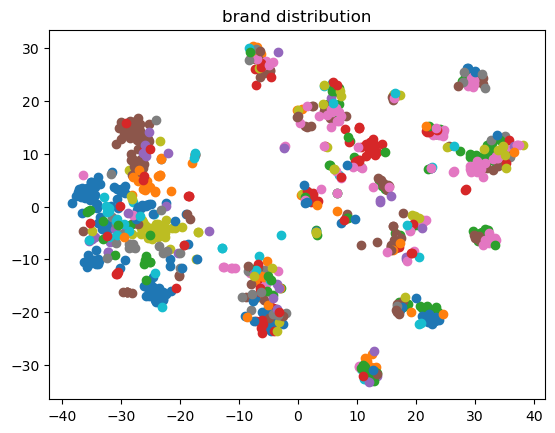

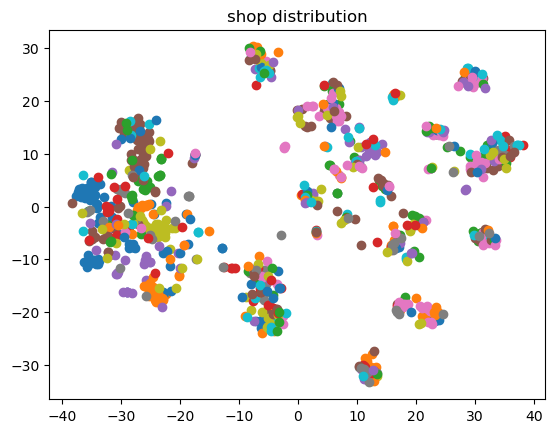

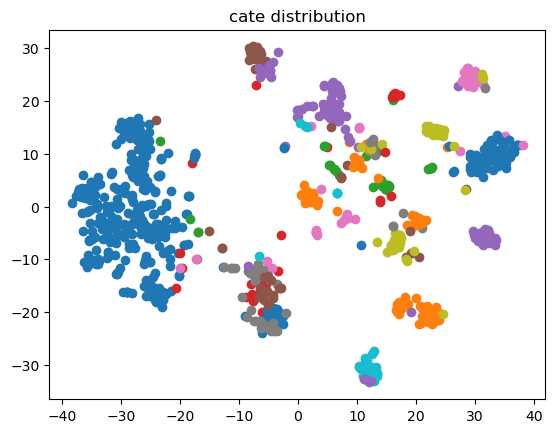

In [17]:
from sklearn.manifold import TSNE

res = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeds)
import matplotlib.pyplot as plt

brand_color_idx, shop_color_idx, cate_color_idx = {}, {}, {}
for i in range(num_skus):
    brand_color_idx.setdefault(encode_sku_info[i][1], [])
    brand_color_idx[encode_sku_info[i][1]].append(i)
    shop_color_idx.setdefault(encode_sku_info[i][2], [])
    shop_color_idx[encode_sku_info[i][2]].append(i)
    cate_color_idx.setdefault(encode_sku_info[i][3], [])
    cate_color_idx[encode_sku_info[i][3]].append(i)

plt.figure()
for c, idx in brand_color_idx.items():
    plt.scatter(res[idx, 0], res[idx, 1], label=c)  # c=node_colors)
plt.title('brand distribution')
# plt.savefig('brand_dist.png')

plt.figure()
for c, idx in shop_color_idx.items():
    plt.scatter(res[idx, 0], res[idx, 1], label=c)  # c=node_colors)
plt.title('shop distribution')
# plt.savefig('shop_dist.png')

plt.figure()
for c, idx in cate_color_idx.items():
    plt.scatter(res[idx, 0], res[idx, 1], label=c)  # c=node_colors)
plt.title('cate distribution')
# plt.savefig('cate_dist.png')

In [18]:
# 稀疏比
sparsity = 1 - train_g.num_edges() / (train_g.num_nodes() * (train_g.num_nodes() - 1))
sparsity

0.9945244107995375

In [20]:
print(len(all_sku_info))
print(len(sku_info_encoder['sku']))
cold_skus = set(all_sku_info) - set(sku_info_encoder['sku'])
print(len(cold_skus))

352539
1003
351536


In [21]:
valid_cold_skus = {}
for cold_sku_id in cold_skus:
    try:
        valid_cold_skus[cold_sku_id] = [0, -1, -1, -1]
        decode_brand = sku_info_encoder['brand'][all_sku_info[cold_sku_id][0]]
        valid_cold_skus[cold_sku_id][1] = decode_brand
        decode_shop = sku_info_encoder['shop'][all_sku_info[cold_sku_id][1]]
        valid_cold_skus[cold_sku_id][2] = decode_shop
        decode_cate = sku_info_encoder['cate'][all_sku_info[cold_sku_id][2]]
        valid_cold_skus[cold_sku_id][3] = decode_cate
    except:
        continue

valid_cold_skus = {key: val for key, val in valid_cold_skus.items() if min(val) != -1}
len(valid_cold_skus)

23763

In [22]:
batch_cold_skus = valid_cold_skus.keys()
batch_cold_skus_si = [valid_cold_skus[key] for key in valid_cold_skus]
batch_cold_skus_si = torch.IntTensor(batch_cold_skus_si).view(len(batch_cold_skus), 4)
model.get_cold_item_embedding(batch_cold_skus_si)

tensor([[ 0.9705,  0.2385, -0.2456,  ...,  0.1610, -0.6772, -0.6796],
        [ 0.4053,  0.8993,  0.4973,  ..., -0.4784, -0.3089, -0.7231],
        [ 1.1208,  0.1927, -0.1562,  ...,  0.4155, -0.3629, -0.5186],
        ...,
        [ 0.9297, -0.7765,  0.4121,  ..., -1.0950, -0.7364, -0.3523],
        [ 1.4786, -1.2618, -0.0555,  ..., -1.7279, -1.2710, -1.3325],
        [ 0.8771,  0.1122, -0.7596,  ..., -1.1283, -1.3141, -1.3114]],
       grad_fn=<DivBackward0>)